# Анализ результатов A/B-тестирования в бизнесе

В этом проекте анализировались данные крупного интернет-магазина, который работает преимущественно в Азии. Магазин недавно провёл А/B-тест, чтобы проверить новую платёжную воронку: гипотеза заключалась в том, что новая платёжная воронка увеличит конверсию в покупку. Цель исследования — проанализировать результаты А/B-теста, который назывался new_payment_funnel_test_summer_2025.

## Описание данных

Данные состоят из нескольких таблиц:

- `new_users_test_2025.csv` — данные всех пользователей, зарегистрировавшихся в интернет-магазине с 1 по 14 июня 2025 года.

- `sessions_test_2025.csv` — данные всех сессий новых пользователей с 1 по 21 июня 2025 года.

- `purchases_test_2025.csv` — данные всех покупок новых пользователей с 1 по 21 июня 2025 года.  

- `participants_test_2025.csv` — данные участников тестов.

Структура данных выглядит следующим образом:

Таблица `new_users_test_2025.csv` состоит из полей:

- `user_id` — уникальный идентификатор пользователя;

- `first_date` — дата регистрации;

- `region` — регион, к которому относится пользователь;

- `device` — устройство, с которого происходила регистрация.

Таблица `sessions_test_2025.csv` состоит из полей:

- `user_id` — уникальный идентификатор пользователя;

- `session_start` — дата начала сессии;

- `session_duration` — длительность сессии в минутах.

Таблица `purchases_test_2025.csv` состоит из полей:

- `user_id` — уникальный идентификатор пользователя;

- `event_dt` — дата и время покупки;

- `revenue` — стоимость покупки в долларах.

Таблица `participants_test_2025.csv` состоит из полей:

- `user_id` — уникальный идентификатор пользователя;

- `group` — группа А/B-теста;

- `ab_test` — название А/B-теста.



## Работа над проектом

In [1]:
#загружаем необходимые библиотеки
import pandas as pd
from matplotlib import pyplot as plt

import math
from scipy import stats

from statsmodels.stats.proportion import proportions_ztest

### Шаг 1. Загрузка и подготовка данных
Загружаем данные, преобразуем даты и веремя:

In [2]:
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/new_users_test_2025.csv')
sessions = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_test_2025.csv')
purchases = pd.read_csv('https://code.s3.yandex.net/datasets/purchases_test_2025.csv')
test_participants = pd.read_csv('https://code.s3.yandex.net/datasets/participants_test_2025.csv')

In [3]:
display(new_users.head())
display(sessions.head())
display(purchases.head())
display(test_participants.head())

,user_id,first_date,region,device
0,D72A72121175D8BE,2025-06-01,South Asia,iPhone
1,F1C668619DFE6E65,2025-06-01,Southeast Asia,iPhone
2,2E1BF1D4C37EA01F,2025-06-01,Central Asia,Mac
3,50734A22C0C63768,2025-06-01,Central Asia,Android
4,E1BDDCE0DAFA2679,2025-06-01,Southeast Asia,iPhone


,user_id,session_start,session_duration
0,D72A72121175D8BE,2025-06-01 05:51:20,1.0
1,F1C668619DFE6E65,2025-06-01 15:28:14,5.0
2,2E1BF1D4C37EA01F,2025-06-01 16:19:36,3.0
3,50734A22C0C63768,2025-06-01 21:06:51,1.0
4,E1BDDCE0DAFA2679,2025-06-01 10:03:00,2.0


,user_id,event_dt,revenue
0,50734A22C0C63768,2025-06-01 21:06:51,4.99
1,0FC21E6F8FAA8DEC,2025-06-01 06:36:08,4.99
2,9CD9F34546DF254C,2025-06-01 14:40:29,99.99
3,1FD7660FDF94CA1F,2025-06-01 04:53:00,4.99
4,E6AF85675078215D,2025-06-01 11:40:09,4.99


,user_id,group,ab_test
0,6A8825D752FCFFB6,A,new_payment_funnel_test_summer_2025
1,0B75608CBBA59791,B,new_payment_funnel_test_summer_2025
2,6B9D2F7685B83C73,A,new_payment_funnel_test_summer_2025
3,6435D4C2E66A7F75,B,new_payment_funnel_test_summer_2025
4,4F815438BBD2BB7E,A,new_payment_funnel_test_summer_2025


In [4]:
display(new_users.info())
display(sessions.info())
display(purchases.info())
display(test_participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131486 entries, 0 to 131485
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     131486 non-null  object
 1   first_date  131486 non-null  object
 2   region      131486 non-null  object
 3   device      131486 non-null  object
dtypes: object(4)
memory usage: 4.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491443 entries, 0 to 491442
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           491443 non-null  object 
 1   session_start     491443 non-null  object 
 2   session_duration  491443 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149152 entries, 0 to 149151
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   149152 non-null  object 
 1   event_dt  149152 non-null  object 
 2   revenue   149152 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291 entries, 0 to 3290
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3291 non-null   object
 1   group    3291 non-null   object
 2   ab_test  3291 non-null   object
dtypes: object(3)
memory usage: 77.3+ KB


None

In [5]:
# преобразование дат к нужному типу данных
new_users['first_date'] = pd.to_datetime(new_users['first_date']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start']).dt.date
purchases['event_dt'] = pd.to_datetime(purchases['event_dt']).dt.date

Изучим участников теста:

In [6]:
test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                             group         
new_login_screen_apac               A          107
                                    B          118
new_payment_funnel_test_summer_2025 A         1598
                                    B         1468

Нам нужно проанализировать именно А/В тест - `new_payment_funnel_test_summer_2025`, поэтому проведем фильтрацию необходимых данных

In [7]:
# преобразуем к ттипу datetime64
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

# Фильтруем данные по нужному тесту 
test_name = "new_payment_funnel_test_summer_2025"
test_participants = test_participants[test_participants['ab_test'] == test_name]

# Оставляем в остальных таблицах только участников теста
test_new_users = new_users[new_users['user_id'].isin(test_participants['user_id'])].merge(test_participants, on='user_id')
test_sessions = sessions[sessions['user_id'].isin(test_participants['user_id'])].merge(test_participants, on='user_id')
test_purchases = purchases[purchases['user_id'].isin(test_participants['user_id'])].merge(test_participants, on='user_id')

Изучаем состав участников теста по регионам:

In [8]:
users_by_region_test = test_new_users.groupby('region').agg({'user_id':'nunique'}).rename(columns = {'user_id': 'Участники теста'})
users_by_region_test['% участников по регионам']= (users_by_region_test['Участники теста'] / users_by_region_test['Участники теста'].sum()).round(2)
users_by_region_test= users_by_region_test.sort_values(by = 'Участники теста', ascending=False)
users_by_region_test

,Участники теста,% участников по регионам
region,,
Southeast Asia,2951,0.96
Central Asia,47,0.02
East Asia,42,0.01
South Asia,26,0.01


Изучаем распределение участников теста по группам для проверки корректности распределения

In [9]:
test_participants.head()

,user_id,group,ab_test
0,6A8825D752FCFFB6,A,new_payment_funnel_test_summer_2025
1,0B75608CBBA59791,B,new_payment_funnel_test_summer_2025
2,6B9D2F7685B83C73,A,new_payment_funnel_test_summer_2025
3,6435D4C2E66A7F75,B,new_payment_funnel_test_summer_2025
4,4F815438BBD2BB7E,A,new_payment_funnel_test_summer_2025


In [10]:
#Кол-во участников по группам:
users_A= test_participants[test_participants['group']=='A']['user_id'].nunique()
users_B= test_participants[test_participants['group']=='B']['user_id'].nunique()

In [11]:
grouped_users_test = test_participants.groupby(['ab_test', 'group'],as_index=False).agg({'user_id':'nunique'})
print("Распределение участников по группам:")
print(grouped_users_test)

Распределение участников по группам:
                               ab_test group  user_id
0  new_payment_funnel_test_summer_2025     A     1598
1  new_payment_funnel_test_summer_2025     B     1468


In [12]:
# разница в кол-ве участников по группам
diff_grouped_users= round(abs(users_A-users_B)*100/users_A,2)
print(f'разница в кол-ве участников по группам {diff_grouped_users}%')

разница в кол-ве участников по группам 8.14%


Тестовые данные корректно разделены между контрольной и экспериментальной группами. Группировка по переменным `"ab_test"` и `"group"` с подсчётом уникальных идентификаторов пользователей позволяет убедиться, что количество участников в каждой группе примерно одинаково.

### Шаг 2. Исследовательский анализ данных теста

#### 1. Построить графики кумулятивной динамики метрик и проанализировать их

In [13]:
# Группируем данные по дате и группе, получаем ежедневное количество новых пользователей
cumul_users = test_new_users.groupby(['first_date', 'group']).agg({'user_id': 'nunique'}).reset_index()
cumul_users = cumul_users.sort_values('first_date')
#Создаём столбец для накопительных значений c помощью формулы cumsum()
cumul_users['cum_users'] = cumul_users.groupby('group')['user_id'].cumsum()
cumul_users

,first_date,group,user_id,cum_users
0,2025-06-01,A,166,166
1,2025-06-01,B,161,161
2,2025-06-02,A,107,273
3,2025-06-02,B,93,254
4,2025-06-03,A,82,355
5,2025-06-03,B,72,326
6,2025-06-04,A,80,435
7,2025-06-04,B,67,393
8,2025-06-05,A,103,538
9,2025-06-05,B,101,494


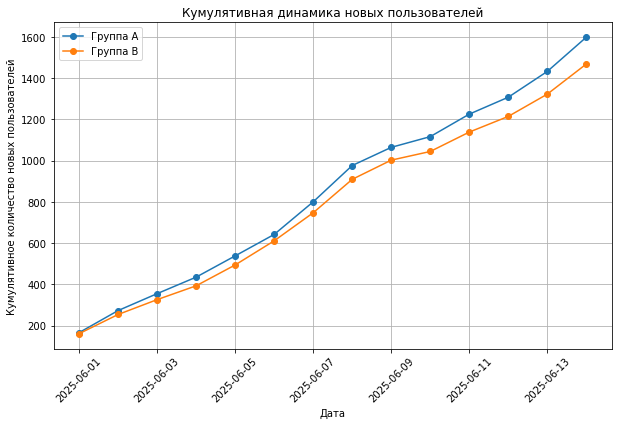

In [14]:
# Строим график накопительной динамики новых пользователей по группам
plt.figure(figsize=(10, 6))
for grp in cumul_users['group'].unique():
    grp_data = cumul_users[cumul_users['group'] == grp]
    plt.plot(grp_data['first_date'], grp_data['cum_users'], marker='o', label=f'Группа {grp}')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное количество новых пользователей')
plt.title('Кумулятивная динамика новых пользователей')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Строим график кумулятивной динамики сессий:

In [15]:
# График кумулятивной динамики сессий
# Группируем данные по дате начала сессии и тестовой группе, считаем количество сессий
cml_sessions = test_sessions.groupby(['session_start', 'group']).size().rename('session_count').reset_index()
cml_sessions = cml_sessions.sort_values('session_start')
# Вычисляем кумулятивное количество сессий для каждой группы
cml_sessions['cml_sessions'] = cml_sessions.groupby('group')['session_count'].cumsum()
cml_sessions

,session_start,group,session_count,cml_sessions
0,2025-06-01,A,166,166
1,2025-06-01,B,161,161
2,2025-06-02,A,192,358
3,2025-06-02,B,178,339
4,2025-06-03,A,194,552
5,2025-06-03,B,164,503
6,2025-06-04,A,187,739
7,2025-06-04,B,194,697
8,2025-06-05,A,228,967
9,2025-06-05,B,220,917


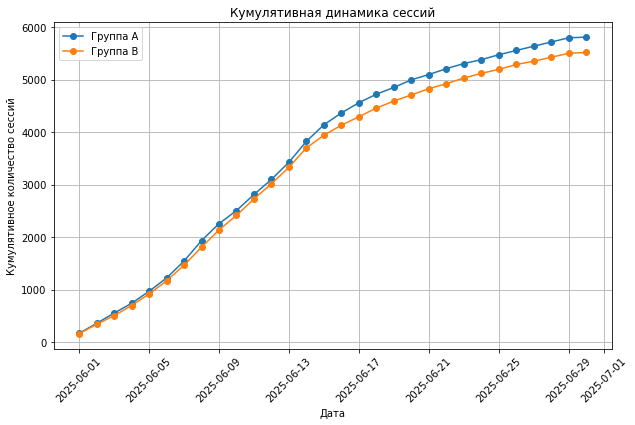

In [16]:
# Строим график
plt.figure(figsize=(10, 6))
for grp in cml_sessions['group'].unique():
    grp_data = cml_sessions[cml_sessions['group'] == grp]
    plt.plot(grp_data['session_start'], grp_data['cml_sessions'], marker='o', label=f'Группа {grp}')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное количество сессий')
plt.title('Кумулятивная динамика сессий')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Предварительный вывод по графикам: во всех рассматриваемых метриках (новые пользователи и сессии) результаты группы A немного лучше результатов группы B. Визуально разница не кажется огромной, но она устойчиво сохраняется на протяжении теста.

#### 2. Ответить на вопросы

Какая была конверсия в разных группах?

In [17]:
# Посчитаем по группам пользователей, совершивших покупку
purchased_users = test_purchases.groupby('group')['user_id'].nunique()
# Посчитаем общее количество пользователей по группам
total_users = test_new_users.groupby('group')['user_id'].nunique()
display(purchased_users)
display(total_users)
# Рассчитаем конверсию
conversion = (purchased_users / total_users).reset_index().rename(columns={0: 'conversion'})

print("\nКонверсия по группам (покупок / регистраций):")
print(conversion)

group
A    472
B    270
Name: user_id, dtype: int64

group
A    1598
B    1468
Name: user_id, dtype: int64


Конверсия по группам (покупок / регистраций):
  group   user_id
0     A  0.295369
1     B  0.183924


Результаты показывают, что конверсия группы A (29.5%) значительно выше по сравнению с группой B (18.4%). Это может говорить о том, что тестируемый вариант в группе A более эффективен в совершении покупок на основе регистраций.

Как выглядит кумулятивная динамика покупок?

In [18]:
# Группируем данные по дате покупки и тестовой группе, считаем количество покупок
cml_purchases = test_purchases.groupby(['event_dt', 'group']).size().reset_index(name='purchase_count')
cml_purchases = cml_purchases.sort_values('event_dt')
# Вычисляем кумулятивное количество покупок для каждой группы 
# Создаём столбец для накопительных значений
cml_purchases['cml_purchases'] = cml_purchases.groupby(['group'])['purchase_count'].cumsum()
cml_purchases

,event_dt,group,purchase_count,cml_purchases
0,2025-06-01,A,44,44
1,2025-06-01,B,48,48
2,2025-06-02,A,49,93
3,2025-06-02,B,46,94
4,2025-06-03,A,38,131
5,2025-06-03,B,46,140
6,2025-06-04,A,37,168
7,2025-06-04,B,52,192
8,2025-06-05,A,71,239
9,2025-06-05,B,39,231


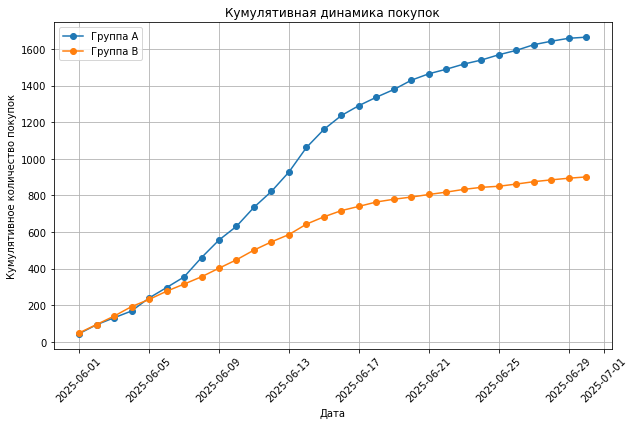

In [19]:
# Строим график кумулятивной динамики покупок по группам
plt.figure(figsize=(10, 6))
for grp in cml_purchases['group'].unique():
    grp_data = cml_purchases[cml_purchases['group'] == grp]
    plt.plot(grp_data['event_dt'], grp_data['cml_purchases'], marker='o', label=f'Группа {grp}')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное количество покупок')
plt.title('Кумулятивная динамика покупок')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Виден рост у группы А. Для окончательных выводов о статистической значимости этой разницы необходимо проверить метрики с помощью соответствующих статистических тестов (например, z-теста или теста Манна — Уитни), а также убедиться, что тест соответствует всем требованиям технического задания (сроки проведения, достаточный размер выборки и так далее).

### Шаг 3. Проверка гипотез
Магазин недавно провёл А/B-тест, чтобы проверить новую платёжную воронку: гипотеза заключалась в том, что **новая платёжная воронка увеличит конверсию в покупку**. Нам нужно проанализировать результаты А/B-теста, который назывался new_payment_funnel_test_summer_2025.

Проведём z-тест для проверки статистической значимости разницы конверсии между группами (например, между группами A и B).

 z-тест:
1. Тип данных — пропорции (конверсии). Когда сравнивают две доли (например, долю пользователей, которые что-либо купили, от общего количества пользователей в каждой группе), классическим инструментом является z-тест для пропорций.


2. Цель — сравнить две независимые выборки. В эксперименте две независимые группы (A и B), и нужно проверить, существует ли между ними статистически значимая разница в доле успехов (конверсии). Для этой задачи z-тест подходит для двух независимых пропорций 

In [20]:
groups = list(test_participants['group'].unique())
groups

['A', 'B']

In [21]:
# Проверяем наличие групп A и B
if 'A' in groups and 'B' in groups:
    # count: количество пользователей, совершивших покупку, в каждой группе
    count = [purchased_users['A'], purchased_users['B']]
    # nobs: общее количество пользователей в каждой группе
    nobs = [total_users['A'], total_users['B']]

    stat, p_value = proportions_ztest(count, nobs)
    print(f"\nРезультаты Z-теста для конверсии:\n"
          f"Статистика = {stat:.2f}, p-value = {p_value:.3f}")
else:
    print("\nДля проведения Z-теста требуются как минимум группы A и B.")



Результаты Z-теста для конверсии:
Статистика = 7.20, p-value = 0.000


Критерий показывает, что между группами действительно существуют статистически значимые различия.

### Шаг 4. Формулирование выводов и рекомендаций

Сформулировать выводы по результатам тестирования:

- Был ли тест проведён согласно техническому заданию?
- Было ли распределение на тестовые группы корректным?
- Наблюдается ли различие в метрике конверсии между тестовыми группами?

Выводы:

- Тест был проведён в соответствии с ТЗ с небольшими, практически незначительными отклонениями.

- Между группами наблюдаются статистически значимые различия: у группы А более высокий уровень конверсии в покупку, чем у группы В.

Рекомендации для заказчика:

- Новая платёжная воронка работает хуже, чем старая. Не рекомендовано её внедрять для всех пользователей.
- Конверсия снизилась — можно предположить, что в момент первой покупки у части пользователей возникают технические сложности, и этот момент нужно протестировать.